<a id='top'></a>

# TransferMarkt Player Recorded Transfer Fees Data Engineering
##### Notebook to engineer player recorded transfer fee data scraped from [TransferMarkt](https://www.transfermarkt.co.uk/).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 22/08/2021<br>
Notebook last updated: 22/08/2021

![title](../../img/transfermarkt-logo-banner.png)

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers transfer data data from [TransferMarkt](https://www.transfermarkt.co.uk/) provided by [ewenme](https://github.com/ewenme/transfers), and manipulates this landed data as DataFrames using [pandas](http://pandas.pydata.org/) and [matplotlib](https://matplotlib.org/) for visualisation.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/TransferMarkt%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>
This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations.

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
#import pandas_profiling as pp
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Flatten lists
from functools import reduce

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Currency Convert
from forex_python.converter import CurrencyRates

# APIs
from tyrone_mings import * 

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2


### Defined Filepaths

In [3]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Defined Variables

In [5]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Lists

In [4]:
# Defined Lists

## Define list of league codes
df_leagues = pd.read_csv(data_dir_tm + '/reference/tm_leagues_comps.csv')
lst_league_codes = df_leagues['league_code'].to_numpy().tolist()

## Define list of 'Big 5' European Leagues and MLS league names
lst_big5_mls_leagues = ['1 Bundesliga', 'Ligue 1', 'Premier League', 'Serie A', 'Primera Division', 'MLS']

## Define list of 'Big 5' European Leagues and MLS codes
lst_big5_mls_league_codes = ['GB1', 'FR1', 'L1', 'IT1', 'ES1', 'MLS1']

### Defined Dictionaries

In [30]:
### Defined Dictionaries

## League names and TM codes
dict_league_codes = {'Primera Division': 'ES1',
                     'Ligue 1': 'FR1',
                     'Premier League': 'GB1',
                     'Championship': 'GB2',
                     'Serie A': 'IT1',
                     '1 Bundesliga': 'L1',
                     'MLS': 'MLS1',
                     'Eredivisie': 'NL1',
                     'Liga Nos': 'PO1',
                     'Premier Liga': 'RU1'
                    }

### Notebook Settings

In [6]:
# Display all columns of pandas DataFrames
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook is part of a series of notebooks to scrape, parse, engineer, unify, and the model, culminating in a an Expected Transfer (xTransfer) player performance vs. valuation model. This model aims to determine the under- and over-performing players based on their on-the-pitch output against transfer fee and wages.

This particular notebook is one of several data engineering notebooks, that cleans recorded transfer fee player data from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/).

[TransferMarkt](https://www.transfermarkt.co.uk/) is a German-based website owned by [Axel Springer](https://www.axelspringer.com/en/) and is the leading website for the football transfer market. The website posts football related data, including: scores and results, football news, transfer rumours, and most usefully for us - calculated estimates ofthe market values for teams and individual players.

To read more about how these estimations are made, [Beyond crowd judgments: Data-driven estimation of market value in association football](https://www.sciencedirect.com/science/article/pii/S0377221717304332) by Oliver Müllera, Alexander Simons, and Markus Weinmann does an excellent job of explaining how the estimations are made and their level of accuracy.

This notebook, along with the other notebooks in this project workflow are shown in the following diagram:

![roadmap](../../img/football_analytics_data_roadmap.png)

Links to these notebooks in the [`football_analytics`](https://github.com/eddwebster/football_analytics) GitHub repository can be found at the following:
*    [Webscraping](https://github.com/eddwebster/football_analytics/tree/master/notebooks/1_data_scraping)
     +    [FBref Player Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Player%20Stats%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Bio and Status Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Bio%20and%20Status%20Web%20Scraping.ipynb)
     +    [TransferMarket Player Valuation Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Valuation%20Web%20Scraping.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Webscraping.ipynb)
     +    [Capology Player Salary Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/Capology%20Player%20Salary%20Web%20Scraping.ipynb)
     +    [FBref Team Stats Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/FBref%20Team%20Stats%20Web%20Scraping.ipynb)
*    [Data Parsing](https://github.com/eddwebster/football_analytics/tree/master/notebooks/2_data_parsing)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
*    [Data Engineering](https://github.com/eddwebster/football_analytics/tree/master/notebooks/3_data_engineering)
     +    [FBref Player Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Player%20Stats%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Bio and Status Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Bio%20and%20Status%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Valuation Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Valuation%20Data%20Engineering.ipynb)
     +    [TransferMarkt Player Recorded Transfer Fees Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb)
     +    [Capology Player Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb)
     +    [FBref Team Stats Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Team%20Stats%20Data%20Engineering.ipynb)
     +    [ELO Team Ratings Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
     +    [TransferMarkt Team Recorded Transfer Fee Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Team%20Recorded%20Transfer%20Fee%20Data%20Engineering.ipynb) (aggregated from [TransferMarkt Player Recorded Transfer Fees notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Recorded%20Transfer%20Fees%20Data%20Engineering.ipynb))
     +    [Capology Team Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Team%20Salary%20Data%20Engineering.ipynb) (aggregated from [Capology Player Salary notebook](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb))
*    [Data Unification](https://github.com/eddwebster/football_analytics/tree/master/notebooks/4_data_unification)
     +    [Golden ID for Player Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Player%20Level%20Datasets.ipynb)
     +    [Golden ID for Team Level Datasets](https://github.com/eddwebster/football_analytics/blob/master/notebooks/4_data_unification/Golden%20ID%20for%20Team%20Level%20Datasets.ipynb)
*    [Production Datasets](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets)
     +    [Player Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Player%20Performance/Market%20Value%20Dataset.ipynb)
     +    [Team Performance/Market Value Dataset](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_production_datasets/Team%20Performance/Market%20Value%20Dataset.ipynb)
*    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling)
     +    [Expected Transfer (xTransfer) Modeling](https://github.com/eddwebster/football_analytics/tree/master/notebooks/6_data_analysis_and_projects/expected_transfer_modeling/Expected%20Transfer%20%20Modeling.ipynb)

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.3.1'></a>

### <a id='#section3.1'>3.1. Introduction</a>
Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Data Dictionaries</a>
The [TransferMarkt](https://www.transfermarkt.co.uk/) dataset has six features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `position_number`    | object     |
| `position_description`    | object     |
| `name`    | object     |
| `dob`    | object     |
| `nationality`    | object     |
| `value`    | object     |

<a id='section3.3'></a>

### <a id='#section332'>3.3. Read in Data</a>

In [15]:
# Unify individual CSV files as a single DataFrame

## Show files in directory
all_files = glob.glob(os.path.join(data_dir_tm + f'/raw/transfer_history/*/*/*.csv'))

## Create an empty list of Players URLs
lst_player_transfer_history_all = []

## Loop through list of files and read into temporary DataFrames, appending to Player URL list 
for filename in all_files:
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    lst_player_transfer_history_all.append(df_temp)

## Concatenate the files into a single DataFrame
df_tm_transfer_history_all_raw = pd.concat(lst_player_transfer_history_all, axis=0, ignore_index=True)


# Sort DataFrame
df_tm_transfer_history_all_raw = df_tm_transfer_history_all.sort_values(['league_name', 'season', 'player_name'], ascending=[True, True, True])


# Display DataFrame
df_tm_transfer_history_all_raw.head()

In [43]:
# Export DataFrame
    
##
df_tm_transfer_history_all_raw.to_csv(data_dir_tm + f'/raw/transfer_history/tm_player_transfer_history_latest.csv', index=None, header=True)

##
#df_tm_transfer_history_all_raw.to_csv(data_dir_tm + f'/raw/transfer_history/archive/tm_player_transfer_history_last_updated_{today}.csv', index=None, header=True)

In [19]:
df_tm_transfer_history_all_raw.shape

(169208, 12)

### <a id='#section3.4'>3.4. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

<a id='section3.4.1'></a>

#### <a id='#section3.4.1'>3.4.1. Summary Report</a>
Initial step of the data handling and Exploratory Data Analysis (EDA) is to create a quick summary report of the dataset using [pandas Profiling Report](https://github.com/pandas-profiling/pandas-profiling).

In [ ]:
# Summary of the data using pandas Profiling Report
#pp.ProfileReport(df_tm_transfer_history_all_raw)

<a id='section3.4.2'></a>

#### <a id='#section3.4.2'>3.4.1. Further Inspection</a>
The following commands go into more bespoke summary of the dataset. Some of the commands include content covered in the [pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) summary above, but using the standard [pandas](https://pandas.pydata.org/) functions and methods that most peoplem will be more familiar with.

First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [20]:
# Display the first five rows of the raw DataFrame, df_tm_transfer_history_all_raw
df_tm_transfer_history_all_raw.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
159524,VfB Stuttgart,Adrian Knup,23.0,Centre-Forward,FC Luzern,?,in,Summer,NaN,1 Bundesliga,1992,1992/1993
159671,1. FC Köln,Adrian Spyrka,24.0,Central Midfield,Stuttg. Kickers,"End of loanJun 30, 1992",in,Summer,0.0,1 Bundesliga,1992,1992/1993
159545,Karlsruher SC,Alexander Famulla,31.0,Goalkeeper,FC 08 Homburg,?,out,Summer,NaN,1 Bundesliga,1992,1992/1993
159510,SV Werder Bremen,Alexander Malchow,22.0,Centre-Back,VfB Oldenburg,Free transfer,out,Summer,0.0,1 Bundesliga,1992,1992/1993
159699,SG Dynamo Dresden,Alexander Zickler,18.0,Centre-Forward,D. Dresden U19,-,in,Summer,0.0,1 Bundesliga,1992,1992/1993


In [21]:
# Display the last five rows of the raw DataFrame, df_tm_transfer_history_all_raw
df_tm_transfer_history_all_raw.tail()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
69864,FC Crotone,Zak Ruggiero,20.0,Second Striker,Pro Sesto,loan transfer,out,Winter,NaN,Serie A,2020,2020/2021
69523,SSC Napoli,Zinédine Machach,24.0,Central Midfield,VVV-Venlo,loan transfer,out,Summer,NaN,Serie A,2020,2020/2021
69137,Cagliari Calcio,Zito Luvumbo,18.0,Right Winger,1º de Agosto,£900Th.,in,Summer,0.9,Serie A,2020,2020/2021
69762,Torino FC,Álex Berenguer,25.0,Left Winger,Athletic,£10.80m,out,Summer,10.8,Serie A,2020,2020/2021
69423,Juventus FC,Álvaro Morata,27.0,Centre-Forward,Atlético Madrid,Loan fee:£9.00m,in,Summer,9.0,Serie A,2020,2020/2021


In [22]:
# Print the shape of the raw DataFrame, df_tm_transfer_history_all_raw
print(df_tm_transfer_history_all_raw.shape)

(169208, 12)


In [23]:
# Print the column names of the raw DataFrame, df_tm_transfer_history_all_raw
print(df_tm_transfer_history_all_raw.columns)

Index(['club_name', 'player_name', 'age', 'position', 'club_involved_name',
       'fee', 'transfer_movement', 'transfer_period', 'fee_cleaned',
       'league_name', 'year', 'season'],
      dtype='object')


The dataset has twelve features (columns).

In [24]:
# Data types of the features of the raw DataFrame, df_tm_transfer_history_all_raw
df_tm_transfer_history_all_raw.dtypes

club_name              object
player_name            object
age                   float64
position               object
club_involved_name     object
fee                    object
transfer_movement      object
transfer_period        object
fee_cleaned           float64
league_name            object
year                    int64
season                 object
dtype: object

In [25]:
# Info for the raw DataFrame, df_tm_transfer_history_all_raw
df_tm_transfer_history_all_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169208 entries, 159524 to 69423
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   club_name           169208 non-null  object 
 1   player_name         169208 non-null  object 
 2   age                 169155 non-null  float64
 3   position            169205 non-null  object 
 4   club_involved_name  169208 non-null  object 
 5   fee                 169064 non-null  object 
 6   transfer_movement   169208 non-null  object 
 7   transfer_period     154776 non-null  object 
 8   fee_cleaned         141044 non-null  float64
 9   league_name         169208 non-null  object 
 10  year                169208 non-null  int64  
 11  season              169208 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 16.8+ MB


In [26]:
# Description of the raw DataFrame, df_tm_transfer_history_all_raw, showing some summary statistics for each numberical column in the DataFrame
df_tm_transfer_history_all_raw.describe()

,age,fee_cleaned,year
count,169155.000000,141044.000000,169208.000000
mean,24.364648,0.826293,2008.330008
std,6.266924,3.733992,7.648351
min,-1776.000000,0.000000,1992.000000
25%,21.000000,0.000000,2003.000000
50%,24.000000,0.000000,2009.000000
75%,27.000000,0.000000,2015.000000
max,117.000000,199.800000,2020.000000


<AxesSubplot:>

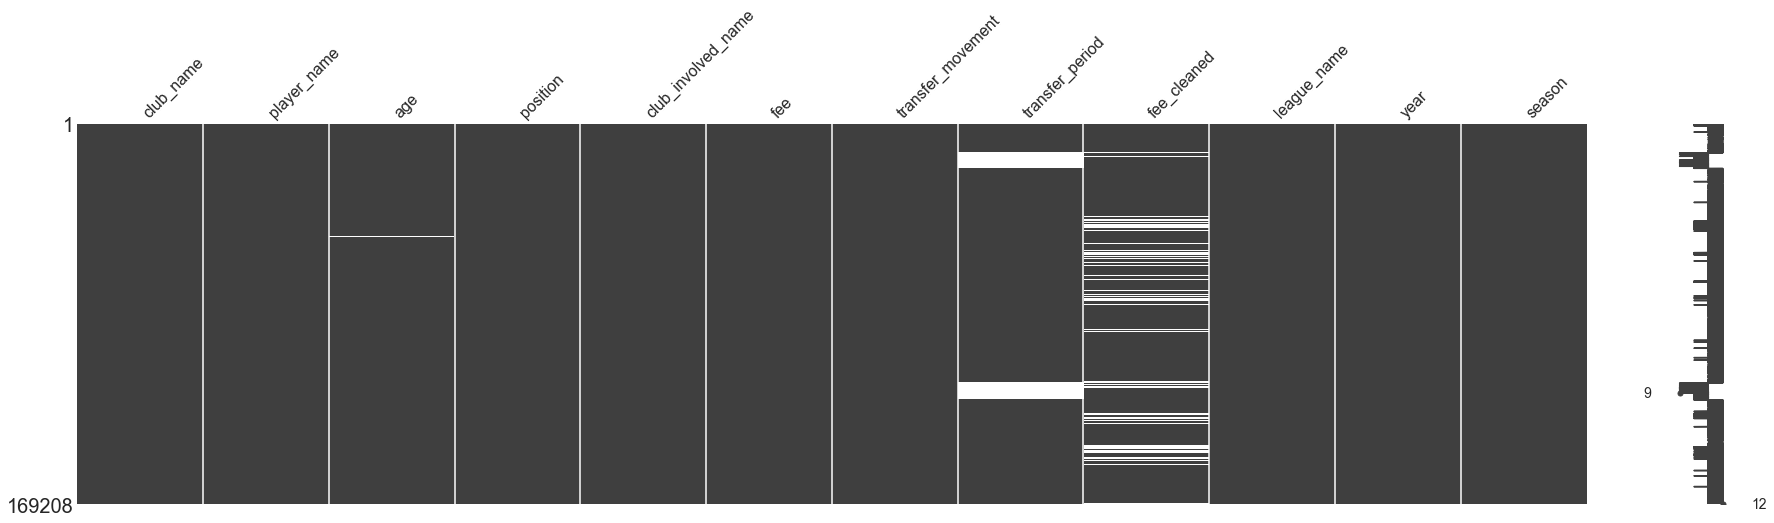

In [27]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm_transfer_history_all_raw
msno.matrix(df_tm_transfer_history_all_raw, figsize = (30, 7))

In [28]:
# Counts of missing values
null_value_stats = df_tm_transfer_history_all_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

age                   53
position               3
fee                  144
transfer_period    14432
fee_cleaned        28164
dtype: int64

The visualisation shows us very quickly that there a few missing values in the `age`, `position`, `fee`, and then more missing values in the `transfer_period` and `fee_cleaned` column.

---

<a id='section4'></a>

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Assign Raw DataFrames to New Engineered DataFrames</a>

In [31]:
# Assign Raw DataFrames to new Engineered DataFrames
df_tm_transfer_history_all = df_tm_transfer_history_all_raw.copy()

In [34]:
df_tm_transfer_history_all.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,league_code
159524,VfB Stuttgart,Adrian Knup,23.0,Centre-Forward,FC Luzern,?,in,Summer,NaN,1 Bundesliga,1992,1992/1993,L1
159671,1. FC Köln,Adrian Spyrka,24.0,Central Midfield,Stuttg. Kickers,"End of loanJun 30, 1992",in,Summer,0.0,1 Bundesliga,1992,1992/1993,L1
159545,Karlsruher SC,Alexander Famulla,31.0,Goalkeeper,FC 08 Homburg,?,out,Summer,NaN,1 Bundesliga,1992,1992/1993,L1
159510,SV Werder Bremen,Alexander Malchow,22.0,Centre-Back,VfB Oldenburg,Free transfer,out,Summer,0.0,1 Bundesliga,1992,1992/1993,L1
159699,SG Dynamo Dresden,Alexander Zickler,18.0,Centre-Forward,D. Dresden U19,-,in,Summer,0.0,1 Bundesliga,1992,1992/1993,L1


### <a id='#section4.2'>4.2. String Cleaning</a>

In [35]:
# Map TM league codes to DataFrame
df_tm_transfer_history_all['league_code'] = df_tm_transfer_history_all['league_name'].map(dict_league_codes)

### <a id='#section4.3'>4.3. Convert to GBP (£)</a>

In [36]:
# Currency Convert
from currency_converter import CurrencyConverter
import math

In [37]:
# Get EUR to GBP exchange rate

## Get latest currency rates
c = CurrencyConverter()

##  Get conversion rate from EUR to GBP
rate_eur_gbp = (c.convert(1, 'EUR', 'GBP'))
rate_eur_gbp

0.90053

In [38]:
# Overwrite
rate_eur_gbp = 0.90
rate_eur_gbp

0.9

In [39]:
# NOT NEEDED AS ALREADY IN POUNDS

# Convert Euros to Pounds
#df_tm_transfer_history_all['fee_cleaned_pounds'] = df_tm_transfer_history_all['fee_cleaned'] * rate_eur_gbp

### <a id='#section4.4'>4.4. Filter Players in 'Big 5' European Leagues and MLS</a>
No MLS data in the dataset currently

In [44]:
df_tm_transfer_history_all['league_name'].unique()

array(['1 Bundesliga', 'Championship', 'Eredivisie', 'Liga Nos',
       'Ligue 1', 'Premier League', 'Premier Liga', 'Primera Division',
       'Serie A'], dtype=object)

In [46]:
# Filter list of 'Big 5' European Leagues and MLS from DataFrame
df_tm_transfer_history_big5 = df_tm_transfer_history_all[df_tm_transfer_history_all['league_name'].isin(lst_big5_mls_leagues)]

In [49]:
df_tm_transfer_history_big5

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,league_code
159524,VfB Stuttgart,Adrian Knup,23.0,Centre-Forward,FC Luzern,?,in,Summer,NaN,1 Bundesliga,1992,1992/1993,L1
159671,1. FC Köln,Adrian Spyrka,24.0,Central Midfield,Stuttg. Kickers,"End of loanJun 30, 1992",in,Summer,0.0,1 Bundesliga,1992,1992/1993,L1
159545,Karlsruher SC,Alexander Famulla,31.0,Goalkeeper,FC 08 Homburg,?,out,Summer,NaN,1 Bundesliga,1992,1992/1993,L1
159510,SV Werder Bremen,Alexander Malchow,22.0,Centre-Back,VfB Oldenburg,Free transfer,out,Summer,0.0,1 Bundesliga,1992,1992/1993,L1
159699,SG Dynamo Dresden,Alexander Zickler,18.0,Centre-Forward,D. Dresden U19,-,in,Summer,0.0,1 Bundesliga,1992,1992/1993,L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69864,FC Crotone,Zak Ruggiero,20.0,Second Striker,Pro Sesto,loan transfer,out,Winter,NaN,Serie A,2020,2020/2021,IT1
69523,SSC Napoli,Zinédine Machach,24.0,Central Midfield,VVV-Venlo,loan transfer,out,Summer,NaN,Serie A,2020,2020/2021,IT1
69137,Cagliari Calcio,Zito Luvumbo,18.0,Right Winger,1º de Agosto,£900Th.,in,Summer,0.9,Serie A,2020,2020/2021,IT1
69762,Torino FC,Álex Berenguer,25.0,Left Winger,Athletic,£10.80m,out,Summer,10.8,Serie A,2020,2020/2021,IT1


In [48]:
df_tm_transfer_history_big5.shape

(93489, 13)

### <a id='#section4.5'>4.5. Filter for 2016/2017 Season Onwards</a>
Separate DataFrame created for transfers from 2016/2017 onwards as this is when the other data sources such as FBref start.

In [52]:
# Filter plays in the Big 5 European Leagues

## Define list of countries
lst_seasons_1617_2122 = ['2016/2017', '2017/2018', '2018/2019', '2019/2020', '2020/2021', '2021/2022']

## Filter list of Big 5 European League countries from DataFrame
df_tm_transfer_history_big5_1617_present = df_tm_transfer_history_big5[df_tm_transfer_history_big5['season'].isin(lst_seasons_1617_2122)]

In [54]:
df_tm_transfer_history_big5_1617_present.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season,league_code
166018,1.FSV Mainz 05,Aaron Seydel,20.0,Left Winger,FSV Mainz 05 II,-,in,Winter,0.00,1 Bundesliga,2016,2016/2017,L1
165635,FC Schalke 04,Abdul Rahman Baba,22.0,Left-Back,Chelsea,Loan fee:£450Th.,in,Summer,0.45,1 Bundesliga,2016,2016/2017,L1
165998,Borussia Dortmund,Adrián Ramos,31.0,Centre-Forward,Granada CF,Loan,out,Winter,0.00,1 Bundesliga,2016,2016/2017,L1
165809,FC Augsburg,Albian Ajeti,19.0,Centre-Forward,FC St. Gallen,Loan,out,Summer,0.00,1 Bundesliga,2016,2016/2017,L1
165833,SV Werder Bremen,Alejandro Gálvez,27.0,Centre-Back,SD Eibar,£1.35m,out,Summer,1.35,1 Bundesliga,2016,2016/2017,L1


In [55]:
df_tm_transfer_history_big5_1617_present.shape

(19756, 13)

---

<a id='section5'></a>

## <a id='#section5'>5. Exporting the Engineered DataFrames</a>
Export the two engineered [TransferMarkt](https://www.transfermarkt.co.uk/) DataFrames as CSV files.

In [42]:
# Export DataFrame
    
##
df_tm_transfer_history_all.to_csv(data_dir_tm + f'/engineered/transfer_history/tm_player_transfer_history_latest.csv', index=None, header=True)

##
df_tm_transfer_history_all.to_csv(data_dir_tm + f'/engineered/transfer_history/archive/tm_player_transfer_history_last_updated_{today}.csv', index=None, header=True)

In [ ]:
# FINISH OFF THIS SECTION

In [ ]:
## Filename
file_name = 'tm_player_joined_big5_mls'

## Full season string
full_season_string = '2016/2017 - 2021/2022'

## Short season string
short_season_string = '1617-2122'

In [ ]:
# Export DataFrame as a CSV file

## Export a copy to the 'archive' subfolder of the TM folder, including the date
#df_tm_market_value_bio_status_select.to_csv(data_dir_tm + f'/engineered/{short_season_string}/joined/archive/' + f'{file_name}_{short_season_string}_last_updated_{today}.csv', index=None, header=True)

## Export another copy to the TM folder called 'latest' (can be overwritten)
#df_tm_market_value_bio_status_select.to_csv(data_dir_tm + f'/engineered/{short_season_string}/joined/' + f'{file_name}_{short_season_string}_latest.csv', index=None, header=True)

In [ ]:
# Export DataFrame as a CSV file

## All data
#df_tm_transfer_history_all.to_csv(data_dir_tm + f'/engineered/transfers/archive/' + f'tm_player_transfers_all_last_updated_{today}.csv', index=None, header=True)
#df_tm_transfer_history_all.to_csv(data_dir_tm + f'/engineered/transfers/' + f'tm_transfers_player_all_latest.csv', index=None, header=True)
#df_tm_transfer_history_all.to_csv(data_dir + f'/export/' + f'tm_transfers_player_all_latest.csv', index=None, header=True)


## Big 5 European Leagues
#df_transfers_big5.to_csv(data_dir_tm + f'/engineered/transfers/archive/' + f'tm_player_transfers_big5_last_updated_{today}.csv', index=None, header=True)
#df_transfers_big5.to_csv(data_dir_tm + f'/engineered/transfers/' + f'tm_player_transfers_big5_latest.csv', index=None, header=True)
#df_transfers_big5.to_csv(data_dir + f'/export/' + f'tm_player_transfers_big5_latest.csv', index=None, header=True)

---

<a id='section7'></a>

## <a id='#section6'>6. Summary</a>
This Jupyter notebook engineered scraped football data from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

---

<a id='section7'></a>

## <a id='#section7'>7. Next Steps</a>
The step is to use this data to...

---

<a id='section8'></a>

## <a id='#section8'>8. References</a>

#### Data and Web Scraping
*    [Beyond crowd judgments: Data-driven estimation of market value in association football](https://www.sciencedirect.com/science/article/pii/S0377221717304332) by Oliver Müllera, Alexander Simons, and Markus Weinmann.
*    [06/04/2020: BBC - Premier League squads 'drop £1.6bn in value'](https://www.bbc.co.uk/sport/football/52221463).

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)